In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dropout, Dense, LSTM, CuDNNLSTM, Embedding
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, multilabel_confusion_matrix, confusion_matrix, \
                                        accuracy_score, roc_curve, auc
import matplotlib.pyplot as plt

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
df = pd.read_csv('data/final.zip', compression='zip')

In [3]:
df.head()

,Unnamed: 0,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,TOXIC,...,word_counts,unique_word_counts,clean_text,tokenized,tokenized_no_stopwords,tokenized_stemmed,tokenized_pos,tokenized_lemmatized,tokenized_lemmatized_pos,tokenized_bigram
0,0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,0,...,43,41,explanation why the edits made under my userna...,"['explanation', 'why', 'the', 'edits', 'made',...","['explanation', 'edits', 'made', 'username', '...","['explan', 'edit', 'made', 'usernam', 'hardcor...","[('explanation', 'NN'), ('edits', 'NNS'), ('ma...","['explanation', 'edits', 'made', 'username', '...","['explanation', 'edits', 'make', 'username', '...","[('explanation', 'edits'), ('edits', 'made'), ..."
1,1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,0,...,17,17,daww he matches this background colour i am se...,"['daww', 'he', 'matches', 'this', 'background'...","['daww', 'matches', 'background', 'colour', 's...","['daww', 'match', 'background', 'colour', 'see...","[('daww', 'NN'), ('matches', 'NNS'), ('backgro...","['daww', 'match', 'background', 'colour', 'see...","['daww', 'match', 'background', 'colour', 'see...","[('daww', 'matches'), ('matches', 'background'..."
2,2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,0,...,42,39,hey man i am really not trying to edit war it ...,"['hey', 'man', 'i', 'am', 'really', 'not', 'tr...","['hey', 'man', 'really', 'trying', 'edit', 'wa...","['hey', 'man', 'realli', 'tri', 'edit', 'war',...","[('hey', 'NN'), ('man', 'NN'), ('really', 'RB'...","['hey', 'man', 'really', 'trying', 'edit', 'wa...","['hey', 'man', 'really', 'try', 'edit', 'war',...","[('hey', 'man'), ('man', 'really'), ('really',..."
3,3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,0,...,113,82,more i cannot make any real suggestions on im...,"['more', 'i', 'can', 'not', 'make', 'any', 're...","['make', 'real', 'suggestions', 'improvement',...","['make', 'real', 'suggest', 'improv', 'wonder'...","[('make', 'VB'), ('real', 'JJ'), ('suggestions...","['make', 'real', 'suggestion', 'improvement', ...","['make', 'real', 'suggestion', 'improvement', ...","[('make', 'real'), ('real', 'suggestions'), ('..."
4,4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,0,...,13,13,you sir are my hero any chance you remember wh...,"['you', 'sir', 'are', 'my', 'hero', 'any', 'ch...","['sir', 'hero', 'chance', 'remember', 'page']","['sir', 'hero', 'chanc', 'rememb', 'page']","[('sir', 'NN'), ('hero', 'NN'), ('chance', 'NN...","['sir', 'hero', 'chance', 'remember', 'page']","['sir', 'hero', 'chance', 'remember', 'page']","[('sir', 'hero'), ('hero', 'chance'), ('chance..."


In [4]:
df['comment_text'][0], df['clean_text'][0]

("Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",
 'explanation why the edits made under my username hardcore metallica fan were reverted they were not vandalisms just closure on some gas after i voted at new york dolls fac and please do not remove the template from the talk page since i am retired now')

In [5]:
#return dictionary with word: embedding_vector
def load_embedding(fname):
    embeddings_index = {}
    f = open(fname, encoding="utf8")
    for line in f:
        values = line.split()
        word = values[0]
        try:
            embedding_vector = np.asarray(values[1:], dtype='float32')
        except:
            pass
        embeddings_index[word] = embedding_vector
    f.close()

    return embeddings_index

In [6]:
def build_RNN_model(word_index, embeddings_index, N_CLASSES, MAX_SEQUENCE_LENGTH, EMBEDDING_DIMS, HIDDEN_UNITS, HIDDEN_LAYERS):
    print('Build model...')
    model = Sequential()
    embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIMS))

    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

    model.add(Embedding(len(word_index) + 1,
                              EMBEDDING_DIMS,
                              weights=[embedding_matrix],
                              input_length=MAX_SEQUENCE_LENGTH,
                              trainable=False))

    return_sequences=True
    for i in range(0, HIDDEN_LAYERS):
        if i==HIDDEN_LAYERS-1:
            return_sequences=False 
        
        model.add(CuDNNLSTM(HIDDEN_UNITS, return_sequences=return_sequences))
        model.add(Dropout(0.2))
  
    #model.add(CuDNNLSTM(HIDDEN_UNITS))
    #model.add(Dropout(0.2))
    model.add(Dense(50, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(N_CLASSES, activation='sigmoid'))

    model.compile(loss='binary_crossentropy',
                    optimizer='adam',
                    metrics=['accuracy'])
  
    return model



# Binary Task (toxic vs no_toxic)

In [7]:
text = df.comment_text.values
target = df.TOXIC.values

N_CLASSES=1
MAX_WORDS=20000
MAX_SEQUENCE_LENGTH=100
EMBEDDING_DIMS = 50
HIDDEN_UNITS=50
HIDDEN_LAYERS=2

tokenizer = Tokenizer(num_words=MAX_WORDS) 
tokenizer.fit_on_texts(text)
sequences = tokenizer.texts_to_sequences(text) 
sequences = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

word_index = tokenizer.word_index
embeddings_index = load_embedding("glove.6B.50d.txt")
#embeddings_index = load_embedding("./wiki.simple.vec")

x_train, x_test, y_train, y_test = train_test_split(sequences, target, test_size=0.2, random_state=100)

In [8]:
model = build_RNN_model(word_index, embeddings_index, N_CLASSES, MAX_SEQUENCE_LENGTH, EMBEDDING_DIMS, HIDDEN_UNITS, HIDDEN_LAYERS)
model.summary()

Build model...
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 50)           15012900  
                                                                 
 cu_dnnlstm (CuDNNLSTM)      (None, 100, 50)           20400     
                                                                 
 dropout (Dropout)           (None, 100, 50)           0         
                                                                 
 cu_dnnlstm_1 (CuDNNLSTM)    (None, 50)                20400     
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 50)                2550      
                                                                 
 dropout_2 (Dropout)         (None, 50)  

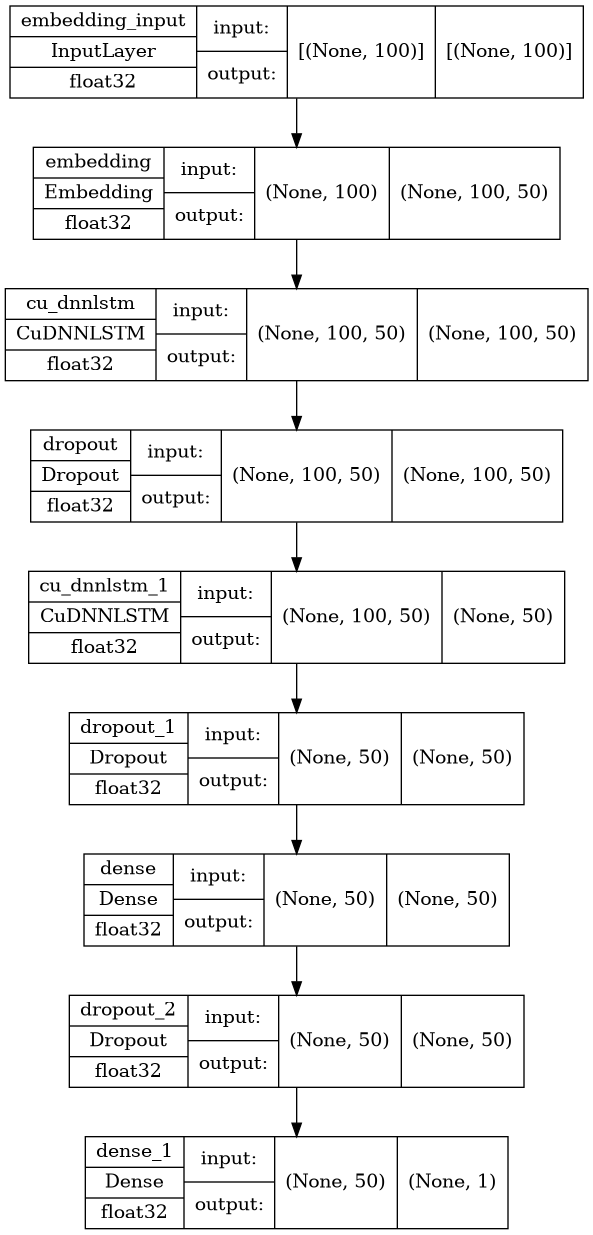

In [9]:
tf.keras.utils.plot_model(model, show_shapes=True, show_dtype=True)

In [11]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

history = model.fit(x_train, y_train,
              validation_data=(x_test, y_test),
              epochs=20,
              batch_size=64,
              callbacks=[es])

Epoch 1/20
2795/2795 [==============================] - 41s 15ms/step - loss: 0.1439 - accuracy: 0.9455 - val_loss: 0.1387 - val_accuracy: 0.9467
Epoch 2/20
2795/2795 [==============================] - 39s 14ms/step - loss: 0.1323 - accuracy: 0.9496 - val_loss: 0.1325 - val_accuracy: 0.9487
Epoch 3/20
2795/2795 [==============================] - 39s 14ms/step - loss: 0.1253 - accuracy: 0.9517 - val_loss: 0.1328 - val_accuracy: 0.9495
Epoch 4/20
2795/2795 [==============================] - 39s 14ms/step - loss: 0.1208 - accuracy: 0.9531 - val_loss: 0.1266 - val_accuracy: 0.9507
Epoch 5/20
2795/2795 [==============================] - 39s 14ms/step - loss: 0.1166 - accuracy: 0.9545 - val_loss: 0.1265 - val_accuracy: 0.9514
Epoch 6/20
2795/2795 [==============================] - 39s 14ms/step - loss: 0.1132 - accuracy: 0.9559 - val_loss: 0.1243 - val_accuracy: 0.9524
Epoch 7/20
2795/2795 [==============================] - 39s 14ms/step - loss: 0.1100 - accuracy: 0.9568 - val_loss: 0.1293 -

In [12]:
history.history

{'loss': [0.14390137791633606,
  0.1322997361421585,
  0.12527428567409515,
  0.12084288150072098,
  0.11663360148668289,
  0.11322422325611115,
  0.10996291786432266,
  0.10678412765264511,
  0.10464385151863098,
  0.10153260082006454,
  0.09906338155269623],
 'accuracy': [0.9455264210700989,
  0.9496418833732605,
  0.951665997505188,
  0.9530863165855408,
  0.9544897675514221,
  0.9558932781219482,
  0.9567599892616272,
  0.9581019878387451,
  0.9586946964263916,
  0.9595781564712524,
  0.9608586430549622],
 'val_loss': [0.13871991634368896,
  0.13254646956920624,
  0.13279898464679718,
  0.1265781819820404,
  0.12648949027061462,
  0.12429254502058029,
  0.12928195297718048,
  0.12723246216773987,
  0.12535706162452698,
  0.12625344097614288,
  0.12596651911735535],
 'val_accuracy': [0.9467456936836243,
  0.9486691951751709,
  0.9495190978050232,
  0.9507269263267517,
  0.9513978958129883,
  0.9523820281028748,
  0.9515991806983948,
  0.951420247554779,
  0.9529635310173035,
  0.952

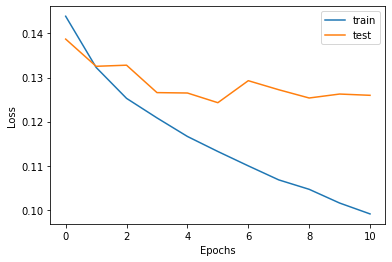

In [13]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

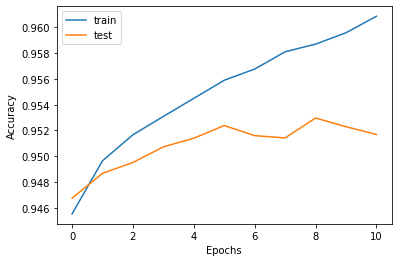

In [14]:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [15]:
predictions_prob = model.predict(x_test)
predictions = predictions_prob.round()

In [16]:
print(classification_report(y_test, predictions))
confusion_matrix(y_test, predictions)

              precision    recall  f1-score   support

           0       0.97      0.98      0.97     40196
           1       0.78      0.72      0.75      4514

    accuracy                           0.95     44710
   macro avg       0.88      0.85      0.86     44710
weighted avg       0.95      0.95      0.95     44710



array([[39290,   906],
       [ 1254,  3260]])

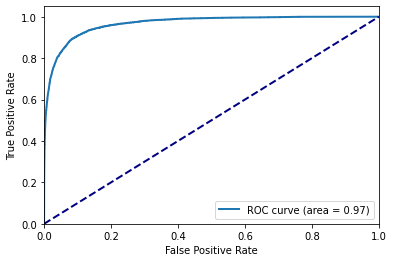

In [17]:
# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test, predictions_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, lw=2, label="ROC curve (area = %0.2f)" % roc_auc)
plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()

# Multi-label classification task
  toxic, severe_toxic, obscene, threat, insult, identity_hate

In [18]:
text = df.comment_text.values
target = df[['toxic','severe_toxic','obscene','threat','insult','identity_hate']].values

N_CLASSES=target.shape[1]
MAX_WORDS=20000
MAX_SEQUENCE_LENGTH=100
EMBEDDING_DIMS = 50
HIDDEN_UNITS=50
HIDDEN_LAYERS=2

tokenizer = Tokenizer(num_words=MAX_WORDS) 
tokenizer.fit_on_texts(text)
sequences = tokenizer.texts_to_sequences(text) 
sequences = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

word_index = tokenizer.word_index
embeddings_index = load_embedding("./glove.6B.50d.txt")
#embeddings_index = load_embedding("./wiki.simple.vec")

x_train, x_test, y_train, y_test = train_test_split(sequences, target, test_size=0.2, random_state=100)

In [19]:
model = build_RNN_model(word_index, embeddings_index, N_CLASSES, MAX_SEQUENCE_LENGTH, EMBEDDING_DIMS, HIDDEN_UNITS, HIDDEN_LAYERS)
model.summary()

Build model...
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 50)           15012900  
                                                                 
 cu_dnnlstm_2 (CuDNNLSTM)    (None, 100, 50)           20400     
                                                                 
 dropout_3 (Dropout)         (None, 100, 50)           0         
                                                                 
 cu_dnnlstm_3 (CuDNNLSTM)    (None, 50)                20400     
                                                                 
 dropout_4 (Dropout)         (None, 50)                0         
                                                                 
 dense_2 (Dense)             (None, 50)                2550      
                                                                 
 dropout_5 (Dropout)         (None, 50)

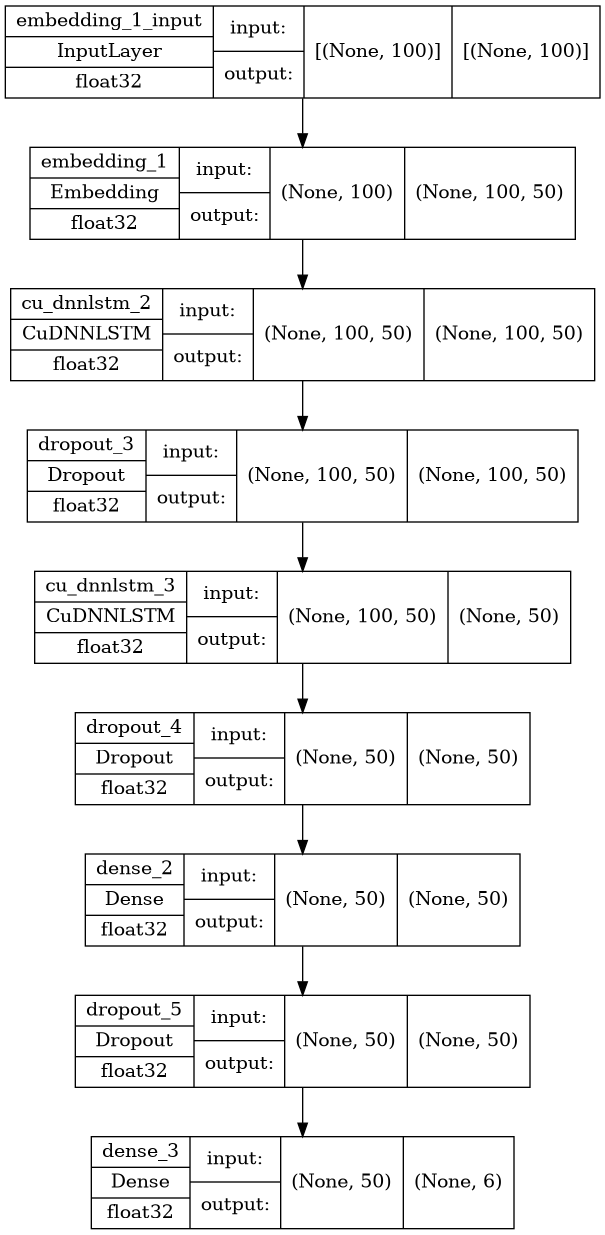

In [20]:
tf.keras.utils.plot_model(model, show_shapes=True, show_dtype=True)

In [21]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

history = model.fit(x_train, y_train,
              validation_data=(x_test, y_test),
              epochs=20,
              batch_size=32,
              callbacks=es)

Epoch 1/20
5589/5589 [==============================] - 73s 13ms/step - loss: 0.0756 - accuracy: 0.9465 - val_loss: 0.0608 - val_accuracy: 0.9952
Epoch 2/20
5589/5589 [==============================] - 71s 13ms/step - loss: 0.0606 - accuracy: 0.9930 - val_loss: 0.0574 - val_accuracy: 0.9952
Epoch 3/20
5589/5589 [==============================] - 71s 13ms/step - loss: 0.0573 - accuracy: 0.9942 - val_loss: 0.0554 - val_accuracy: 0.9952
Epoch 4/20
5589/5589 [==============================] - 72s 13ms/step - loss: 0.0550 - accuracy: 0.9948 - val_loss: 0.0549 - val_accuracy: 0.9952
Epoch 5/20
5589/5589 [==============================] - 71s 13ms/step - loss: 0.0532 - accuracy: 0.9949 - val_loss: 0.0550 - val_accuracy: 0.9952
Epoch 6/20
5589/5589 [==============================] - 71s 13ms/step - loss: 0.0519 - accuracy: 0.9947 - val_loss: 0.0538 - val_accuracy: 0.9952
Epoch 7/20
5589/5589 [==============================] - 71s 13ms/step - loss: 0.0505 - accuracy: 0.9948 - val_loss: 0.0540 -

In [22]:
history.history

{'loss': [0.07561299949884415,
  0.06059461832046509,
  0.057304497808218,
  0.05498223006725311,
  0.053204864263534546,
  0.051856573671102524,
  0.05051802471280098,
  0.04935148358345032,
  0.04829354211688042,
  0.04730997607111931,
  0.04639590531587601,
  0.04542987048625946,
  0.04479517787694931],
 'accuracy': [0.9465497136116028,
  0.9930216670036316,
  0.9942182898521423,
  0.9947941899299622,
  0.9948669075965881,
  0.9946711659431458,
  0.9948389530181885,
  0.9947103261947632,
  0.9947774410247803,
  0.994089663028717,
  0.9943804144859314,
  0.9943189024925232,
  0.9941064119338989],
 'val_loss': [0.060783833265304565,
  0.05741705372929573,
  0.05539725348353386,
  0.054893236607313156,
  0.05500682070851326,
  0.053755827248096466,
  0.05395232513546944,
  0.05260008946061134,
  0.054221317172050476,
  0.05398772284388542,
  0.05363364517688751,
  0.05344381183385849,
  0.05547615885734558],
 'val_accuracy': [0.9952359795570374,
  0.9952359795570374,
  0.99523597955703

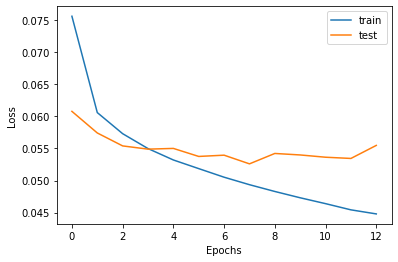

In [24]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

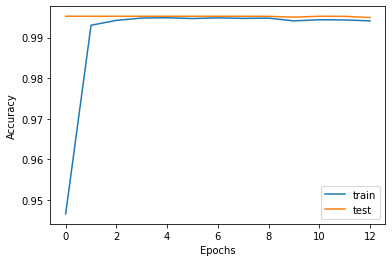

In [25]:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [26]:
predictions_prob = model.predict(x_test)
predictions = predictions_prob.round()

In [27]:
print(classification_report(y_test, predictions, target_names=['toxic','severe_toxic','obscene','threat','insult','identity_hate']))
multilabel_confusion_matrix(y_test, predictions)

               precision    recall  f1-score   support

        toxic       0.82      0.66      0.73      4301
 severe_toxic       0.56      0.28      0.37       383
      obscene       0.80      0.73      0.76      2438
       threat       0.51      0.30      0.38       129
       insult       0.76      0.64      0.69      2264
identity_hate       0.69      0.39      0.50       438

    micro avg       0.79      0.64      0.71      9953
    macro avg       0.69      0.50      0.57      9953
 weighted avg       0.78      0.64      0.70      9953
  samples avg       0.06      0.06      0.05      9953



array([[[39767,   642],
        [ 1464,  2837]],

       [[44242,    85],
        [  276,   107]],

       [[41819,   453],
        [  653,  1785]],

       [[44543,    38],
        [   90,    39]],

       [[41994,   452],
        [  818,  1446]],

       [[44194,    78],
        [  268,   170]]])

In [28]:
print(f'Accuracy score: {accuracy_score(y_test, predictions)}')

Accuracy score: 0.9162156117199731


In [29]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(N_CLASSES):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], predictions_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

In [30]:
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), predictions_prob.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [31]:
print(roc_auc["micro"])

0.9816270721559958


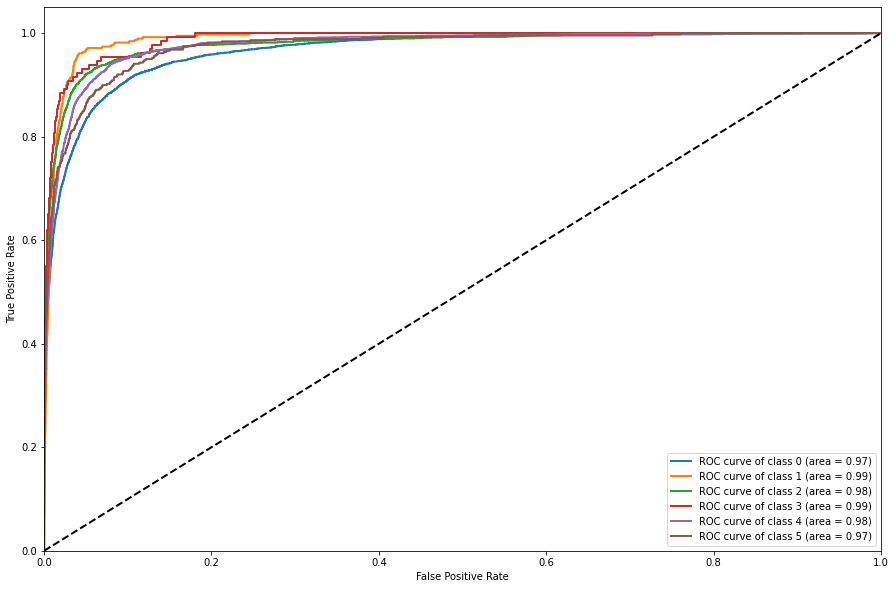

In [32]:
plt.figure(figsize=(15,10))
for i in range(N_CLASSES):
    plt.plot(
        fpr[i],
        tpr[i],
        lw=2,
        label="ROC curve of class {0} (area = {1:0.2f})".format(i, roc_auc[i]),
    )

plt.plot([0, 1], [0, 1], "k--", lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.show()

----

In [ ]:
!pip install fasttext

     |████████████████████████████████| 68 kB 3.3 MB/s 
  Using cached pybind11-2.9.1-py2.py3-none-any.whl (211 kB)
  Created wheel for fasttext: filename=fasttext-0.9.2-cp37-cp37m-linux_x86_64.whl size=3132249 sha256=f0f4087088dcafa23ddcafecb3081d48cc5f8da550ebaa4064f2a152f923a1f8
  Stored in directory: /root/.cache/pip/wheels/4e/ca/bf/b020d2be95f7641801a6597a29c8f4f19e38f9c02a345bab9b
Successfully built fasttext


In [ ]:
import io

def load_vectors(fname):
    fin = io.open(fname, 'r', encoding='utf-8', newline='\n', errors='ignore')
    n, d = map(int, fin.readline().split())
    data = {}
    for line in fin:
        tokens = line.rstrip().split(' ')
        data[tokens[0]] =  np.array([float(v) for v in tokens[1:]])
    return data

In [ ]:
import fasttext.util
fasttext.util.download_model('en', if_exists='ignore')  # English
ft = fasttext.load_model('wiki.simple.vec')

embedding = load_vectors('wiki.simple.vec')


KeyboardInterrupt: ignored

In [ ]:
embedding['ciao']

array([ 1.7826e-01,  4.0100e-01,  2.0527e-01,  1.9235e-01, -1.1595e-02,
        2.4436e-01, -2.4738e-01,  5.7712e-02,  5.1554e-02,  2.1348e-01,
        1.8758e-01, -8.0496e-02, -1.2098e-01,  5.3264e-04,  2.1572e-02,
       -1.1008e-01, -2.7953e-01, -6.3232e-01,  1.5574e-01, -1.2167e-01,
        2.6415e-01, -1.9252e-01,  4.0597e-02,  5.6585e-02,  8.4474e-02,
       -1.3311e-01,  4.0583e-01, -1.2415e-01, -2.0119e-02,  2.0903e-01,
       -3.6345e-01, -3.1191e-02, -2.1535e-01,  4.9066e-01,  2.4230e-01,
       -4.1609e-01,  3.1602e-01,  1.0106e-01, -1.9878e-01,  5.1571e-02,
       -1.2399e-01,  9.2534e-02, -1.7056e-01, -6.1603e-02, -7.1328e-02,
       -3.3209e-02,  1.2767e-01,  2.9721e-01,  3.0716e-01,  3.3349e-01,
       -1.3044e-01, -1.9081e-02, -1.9244e-01, -1.4157e-01, -2.5533e-01,
       -1.8843e-01,  3.2075e-02, -2.6600e-01,  2.4838e-01,  1.8560e-01,
       -6.9006e-02,  3.5800e-01, -2.3988e-01,  6.8542e-03, -4.4892e-01,
       -2.0046e-01, -3.8911e-01, -1.3708e-01, -3.1330e-01,  7.79

In [ ]:
ft.get_dimension()

300

In [ ]:
ft.get_word_vector('')

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [ ]:
df = pd.read_csv('train.csv', engine='python')
df['target'] = (df[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].sum(axis=1) > 0 ).astype(int)
class_names = np.unique(df.target)
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,target
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,0


In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

X = df.comment_text.to_list()
y = df.target

# tokenize the sentences
tokenizer = Tokenizer(lower=False, num_words=10000)
tokenizer.fit_on_texts(X)

X = tokenizer.texts_to_sequences(X)

# pad the sequences
X = pad_sequences(X, maxlen=512)

X.shape

(159571, 512)

In [ ]:
num_tokens = len(tokenizer.word_index) + 2
hits = 0
misses = 0
embedding_dims = 300

# init embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dims))

for word, i in tokenizer.word_index.items():
    #embedding_vector = ft.get_word_vector(word)
    embedding_vector = embedding.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
        
print("Converted %d words (%d misses)" % (hits, misses))

Converted 40349 words (216762 misses)


In [ ]:
embedding_layer = tf.keras.layers.Embedding(
    num_tokens,
    embedding_dims,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False,
)

In [ ]:
from tensorflow.keras import layers

int_sequences_input = keras.Input(shape=(None,), dtype="int64")
embedded_sequences = embedding_layer(int_sequences_input)
x = layers.Dropout(0.2)(embedded_sequences)
x = layers.Conv1D(128, 5, activation="relu")(embedded_sequences)
x = layers.MaxPooling1D(5)(x)
x = layers.Conv1D(128, 5, activation="relu")(x)
x = layers.GlobalMaxPooling1D()(x)
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.2)(x)
#preds = layers.Dense(len(class_names), activation="softmax")(x)
preds = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(int_sequences_input, preds)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding (Embedding)       (None, None, 300)         77133900  
                                                                 
 conv1d (Conv1D)             (None, None, 128)         192128    
                                                                 
 max_pooling1d (MaxPooling1D  (None, None, 128)        0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, None, 128)         82048     
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                              

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
from keras.callbacks import EarlyStopping
epochs = 20
batch_size = 128

early_stopping = EarlyStopping(monitor='val_loss', patience=5)

history = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          callbacks=early_stopping,
          shuffle=True,
          validation_data=(x_test, y_test))

Epoch 1/20
998/998 [==============================] - 70s 61ms/step - loss: 0.2146 - accuracy: 0.9227 - val_loss: 0.1862 - val_accuracy: 0.9333
Epoch 2/20
998/998 [==============================] - 60s 60ms/step - loss: 0.1765 - accuracy: 0.9359 - val_loss: 0.1804 - val_accuracy: 0.9351
Epoch 3/20
998/998 [==============================] - 60s 60ms/step - loss: 0.1609 - accuracy: 0.9408 - val_loss: 0.1905 - val_accuracy: 0.9298
Epoch 4/20
998/998 [==============================] - 60s 60ms/step - loss: 0.1423 - accuracy: 0.9466 - val_loss: 0.1913 - val_accuracy: 0.9333
Epoch 5/20
998/998 [==============================] - 60s 60ms/step - loss: 0.1204 - accuracy: 0.9545 - val_loss: 0.2083 - val_accuracy: 0.9340
Epoch 6/20
998/998 [==============================] - 60s 60ms/step - loss: 0.1021 - accuracy: 0.9608 - val_loss: 0.2272 - val_accuracy: 0.9283
Epoch 7/20
998/998 [==============================] - 61s 61ms/step - loss: 0.0897 - accuracy: 0.9649 - val_loss: 0.2531 - val_accuracy:

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = model.predict(x_test)
print(classification_report(y_test, y_pred.round()))
confusion_matrix(y_test, y_pred.round())

              precision    recall  f1-score   support

           0       0.93      0.98      0.96     28671
           1       0.68      0.35      0.46      3244

    accuracy                           0.92     31915
   macro avg       0.80      0.66      0.71     31915
weighted avg       0.90      0.92      0.90     31915



array([[28141,   530],
       [ 2122,  1122]])

In [ ]:
del X, y, df

In [ ]:
embedding = {}

for word, i in tokenizer.word_index.items():
    embedding_vector = ft.get_word_vector(word)
    embedding[word] = list(embedding_vector)

In [ ]:
len(embedding)

In [ ]:
embedding['ciao']

In [ ]:
import json

out_file = open("embedding.cc.en.300.jigsaw.json", "w")
json.dump(embedding, out_file)
out_file.close()

In [ ]:
import pickle

with open('embedding.cc.en.300.jigsaw.pickle', 'wb') as handle:
    pickle.dump(embedding, handle, protocol=pickle.HIGHEST_PROTOCOL)